In [ ]:
from IMP_CW_env_v2 import MESCEnv
import numpy as np 
from scipy.optimize import minimize, basinhopping

from HeuristicPolicy_file import HeuristicPolicy, Optimizer
from utils import plot_reward_distribution

import matplotlib.pyplot as plt
%matplotlib inline

# **Training environment definition**

In [ ]:
n_retailers = 2
n_DCs = 1
n_suppliers = 1
supply_chain_structure = [[n_retailers] , [n_DCs], n_suppliers]

# **Policy optimization**
### Instantiate objects

In [ ]:
env_train = MESCEnv(supply_chain_structure)
sSpolicy = HeuristicPolicy()

### Run optimization

In [ ]:
# # Uncomment below if local optimization with multiple runs
optimizer = Optimizer(sSpolicy.objective_fcn, env_train)
# options = {'workers':4}
options = None
results = sSpolicy.optimize_policy(env_train, optimizer.calculate_reward, method = 'L-BFGS-B', callback = optimizer.callback, options = options)

## Uncomment below if gloabl optimization with single run
# optimizer = Optimizer(reward_fcn, env_train)
# results = optimize_inventory_policy(env_train, reward_fcn, policy_function_sS, method = 'global')

### Get solution

In [ ]:
optimizer.get_best_solution()
optimal_policy_sS = np.clip(np.floor(optimizer.best_x),a_min=0.,a_max=None).astype(int)

In [ ]:
print(f'Converged: {results.success}')
print(f'Number of iterations: {optimizer.iter} \nBest objective function value: {optimizer.best_f:.2f}\nMaximum reward: {-1*optimizer.best_f:.2f}\nOptimal (s,S) policy: {optimal_policy_sS}')

Converged: True
Number of iterations: 4 
Best objective function value: 213927.50
Maximum reward: -213927.50
Optimal (s,S) policy: [ 16  49  15  50  65 199]


### Visualization: plot reward evolution

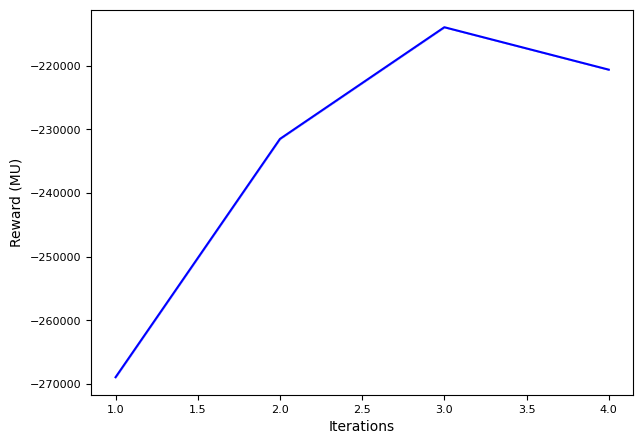

In [ ]:
optimizer.plot_learning_curve()

# **(s,S) Policy evaluation**

Note that here the policy is tested in the same environment where it was trained.

### Test dataset of demands
It will contain 100 samples for testing, each with 52 weeks.

In [ ]:
test_demand_dataset = []
env_train.seed = 42
for _ in range(0,100):
    demands_episode, _ = env_train.sample_demands_episode()
    test_demand_dataset.append(demands_episode)

### Policy evaluation
Set the optimal policy parameters before running the evaluation.

In [ ]:
sSpolicy.policy_param = optimal_policy_sS

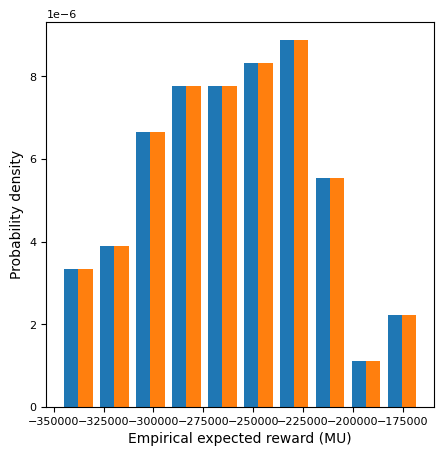

In [ ]:
reward_list = sSpolicy.evaluate_policy(env_train, test_demand_dataset)
plot_reward_distribution(np.vstack([reward_list,reward_list]).T)